In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal
import csv
import scipy.fft as fft  #we use scipy for the fft
import random

# 0. Function 

### 0.1. Function for Fourrier transform

In [2]:
def compute_fourier_transform(signal, sample_rate):
    """
    Computes the Fourier Transform of a given signal.

    Args:
      signal: The input signal (array-like).
      sample_rate: The sampling rate of the signal in Hz.

    Returns:
      xf: Array of frequencies.
      yf: Array of corresponding amplitudes.
    """
    N = len(signal)

    # Compute the Fourier Transform (use np.fft.fft)
    yf = np.fft.fft(signal)

    # Compute the frequency bins (use np.fft.fftfreq)
    xf = np.fft.fftfreq(N, 1/sample_rate)[:N//2]
    return xf,  np.abs(yf[0:N//2])

### 0.2. Function of generating mono-chromatic signal (i.e. Sine wave)

In [3]:
def comb_sine(t,f_arr, phase):
    """
    Generating the combination of sine wave with different f, size of t

    Args: 
        t: maximum time duration (array-like)
        f_arr: different frequency
    Return:
        a: combination of sine wave in different frequenies (within time duration t)
    """
    phase = phase*np.pi/180
    a = np.zeros(np.size(t))
    for f in f_arr:
        a += np.sin(2*np.pi*f*t + phase)

    return a 

### 0.3. Function to limiting the bandwidth 

In [4]:
def BW_limt(data, BW, Fs): 
    """
    Use a n-th order Butterworth Low-pass-filter (LPF) to limiting the bandwidth of signal

    Args:
        data: input signal 
        BW: expected bandwidth limiting (in Hz)
        Fs: Sampling frequency
    Return:
        filtered_signal: signal with the same size input data, whether frequency > BW attenuated by LPF
        
    """
    nyquist_freq = Fs
    cutoff = BW / nyquist_freq 
    
    #normalize cutoff, range from 0 to 1
    b, a = signal.butter(4, cutoff, 'low')  # 4th order Butterworth filter
    # 4: order
    # cutoff: the normalise cutoff frequency
    # low" low pass filter
    # Apply the filter
    filtered_signal = signal.filtfilt(b, a, data)
    return filtered_signal 

### 0.4. Function of generating a white noise spectrum in time-domain 

In [5]:
def gen_noise(t, step):
    """
    Generating a white noise spectrum using random gaussian function with avg (mu) and std (sigma)

    Args:
        t: maximum time duration 
        step: minimum time step 
    Returns:
        [0]: time vector generated by t and step (from 0 to t)
        [1]: generated noise spectrum (in time domain)
    """
    noise = []
    mu = 1
    sigma = 0.2
    Fs = round(1/step) 
    for i in range(int(Fs)):
        temp = random.gauss(mu, sigma)
        noise.append(temp)
    return np.arange(0,t,step), noise

### 0.5. Function of sampling a data set

In [6]:
def sampling(t, signal, Fs, offset=0, jitter=0):
    """
    Samples a time-domain signal at a given sampling rate, with optional 
    time offset and jitter.

    Args:
      t: Time vector of the signal.
      signal: The input signal.
      Fs: The sampling rate in Hz.
      offset: Time offset for shifting the sampling points (in seconds).
              Defaults to 0.
      jitter: Amount of random jitter to add to each sampling point (in seconds).
              Defaults to 0.

    Returns:
      t_sampled: Time vector of the sampled signal.
      sampled_signal: The sampled signal.
    """

    sampling_interval = 1.0 / Fs

    # Generate the new time vector with offset and jitter
    t_sampled = np.arange(t[0] + offset, t[-1] + offset, sampling_interval)
    if jitter > 0:
        t_sampled += np.random.uniform(-jitter, jitter, size=len(t_sampled))

    
    # Interpolate the signal to get the sampled values
    sampled_signal = np.interp(t_sampled, t, signal)

    return t_sampled, sampled_signal

### 0.6. Function of calculating std of a averaging subdivided signal 

In [7]:
def calculate_std_of_averaged_signal(rand_arr, avg_factor):
    """
    Calculates the standard deviation of a signal averaged over 
    different block sizes.

    Args:
      rand_arr: The input signal (array-like).
      avg_factor: An array of averaging factors (block sizes).

    Returns:
      std_arr: An array of standard deviations corresponding to the avg_factor.
    """

    std_arr = np.zeros(len(avg_factor))
    for k, i in enumerate(avg_factor):
        n = len(rand_arr) // i  # Number of blocks
        sig0 = np.zeros(n)
        for j in range(n):
            start = j * i
            end = (j + 1) * i
            sig0[j] = np.mean(rand_arr[start:end])  # Average each block
        std_arr[k] = np.std(sig0)  # Calculate std for the current block size
    return std_arr

### 0.7. Geneating a spectrum of 1/f like and white noise 

In [8]:
def gen_non_stationary_noise(t, step, mu, sigma):
    """
    Generates non-stationary noise by adding flicker noise to 
    Gaussian noise with a time-varying mean.

    Args:
      t: Duration of the noise signal in seconds.
      step: Time step in seconds.
      mu: Mean of the Gaussian noise.
      sigma: Standard deviation of the Gaussian noise.

    Returns:
      time_vector: Time vector.
      noise: Non-stationary noise signal.
    """

    # Generate Gaussian noise with time-varying mean
    num_samples = int(t / step)  # Calculate the number of samples
    time_vector = np.arange(0, t, step)
    noise = np.zeros(num_samples)  # Initialize noise array with the correct size
    for i in range(num_samples):
        mu_t = mu + 0.1 * time_vector[i]  # Linearly increasing mean (you can adjust this)
        noise[i] = random.gauss(mu_t, sigma)

    # Generate flicker noise (with the same number of samples)
    N = num_samples
    f = np.fft.fftfreq(N, 1/step)
    f[0] = 1  # Avoid division by zero
    flicker_spectrum = 1 / np.abs(f)
    flicker_spectrum[0] = 0  # Set DC component to zero
    phases = np.random.uniform(0, 2*np.pi, N)
    flicker_fft = flicker_spectrum * np.exp(1j * phases)
    flicker_noise = np.fft.ifft(flicker_fft)
    flicker_noise = np.real(flicker_noise)

    # Combine Gaussian noise and flicker noise
    noise += flicker_noise*0.001  # Add flicker noise to the Gaussian noise

    return time_vector, noise/(max(noise)/1.5) #/1.5 to normalize the signal 


# 1. Problem of sampling frequency 

The sampling rate of a signal is defined as the number of samples taken per second. According to the Nyquist-Shannon sampling theorem, to accurately reconstruct a signal, the sampling frequency must be strictly greater than twice the highest frequency component present in the signal (including noise).  A higher sampling rate generally leads to a more accurate representation of the original signal, but it also increases data storage and processing requirements. We will provide an example of a sine wave signal with a frequency  f = 4 Hz, sampled at rates of 1.5, 2, and 4 times this frequency. 

In [9]:
t = np.linspace(0, 2*np.pi, 1000) # time duration of simulation.
phase = 90
f_arr = [4] # Frequency of sine wave signal 

sine_wave = comb_sine(t,f_arr, phase)

F_samp = [1.5*f_arr[0], 2*f_arr[0], 4*f_arr[0]] # array of sampling frequency 


In [10]:
def comb_sine_samp(t,f_arr,Fs,phase):
    """
    Generating the combination of sine wave with different f, size of t

    Args: 
        t: maximum time duration (array-like)
        f_arr: different frequency
    Return:
        a: combination of sine wave in different frequenies (within time duration t)
    """
    phase = phase*np.pi/180
    t = max(t)
    step = 1/ Fs
    t = np.arange(0,t,step)
    a = np.zeros(np.size(t))
    for f in f_arr:
        a += np.sin(2*np.pi*f*t + phase)
    return t, a 

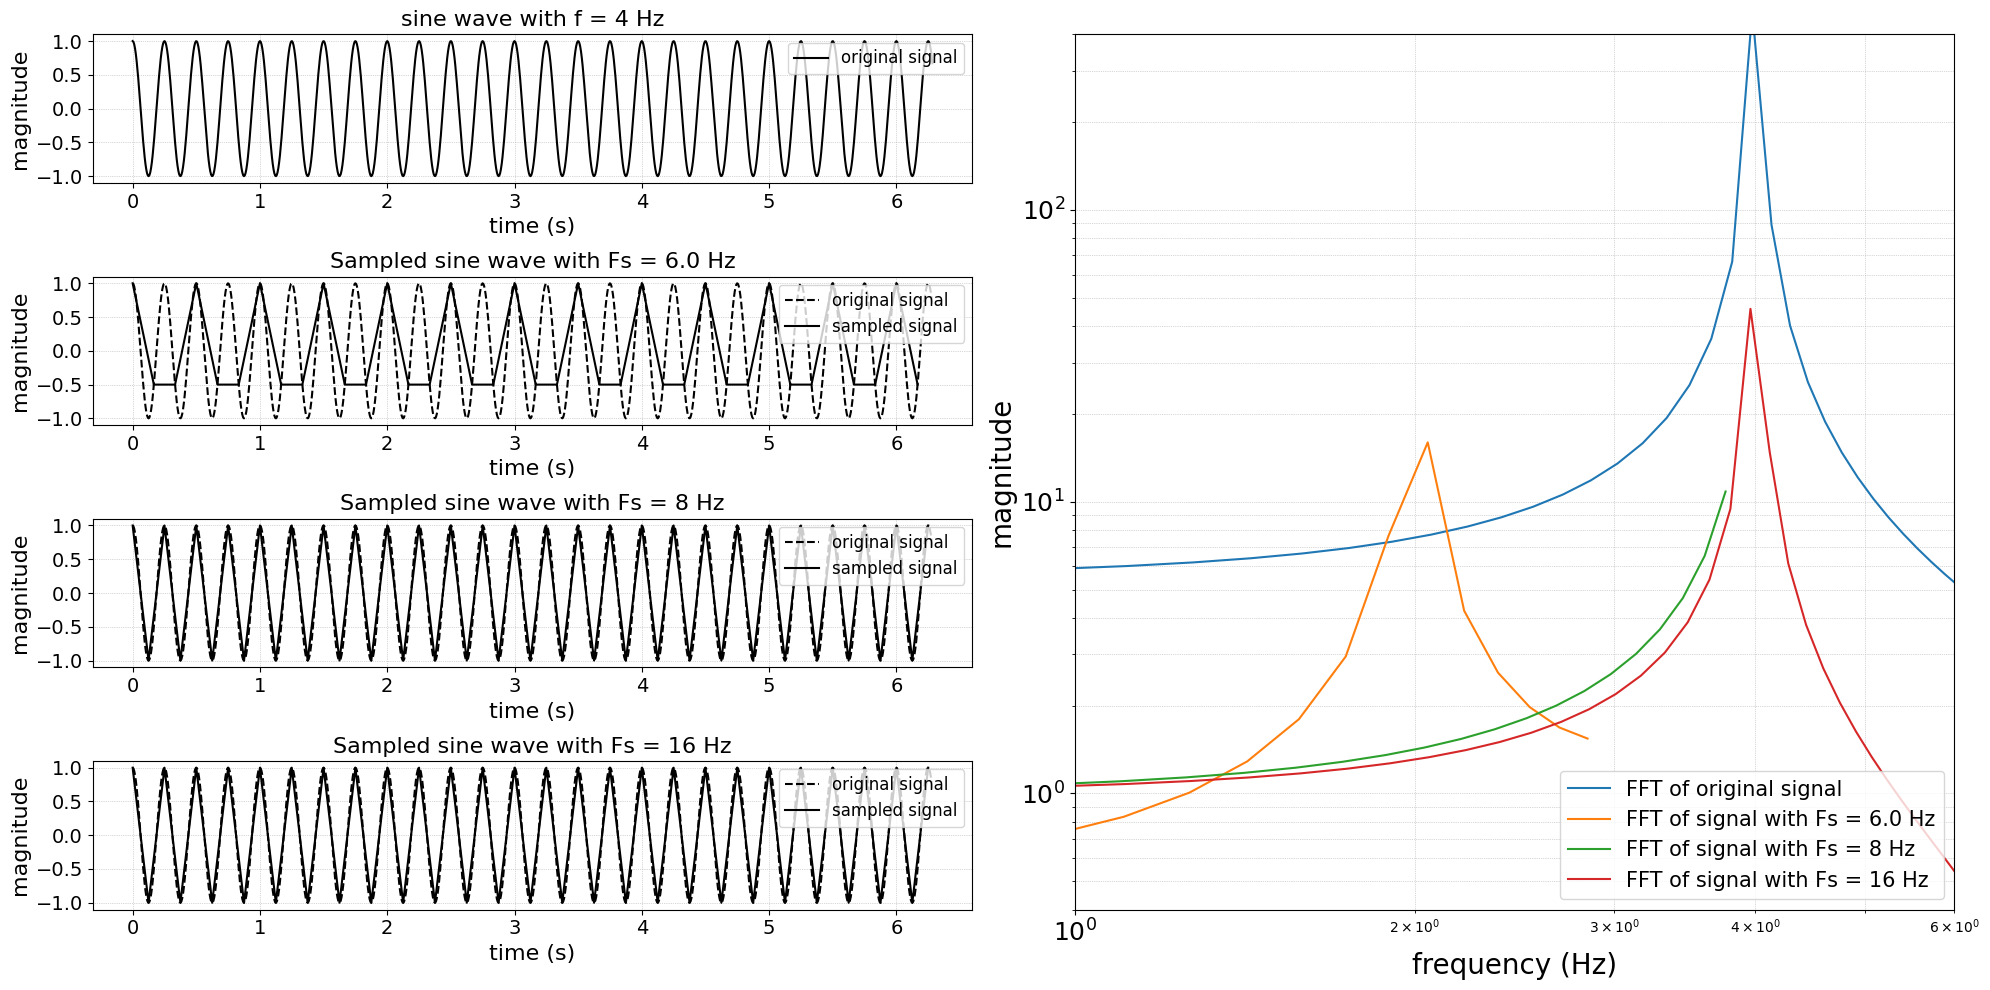

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code for sampling and compute_fourier_transform) ...

plt.figure(figsize=(20, 10))  # Removed constrained_layout

# --- Left Subplots ---

# Original Signal
ax1 = plt.subplot(421)  # Use ax1 for the first subplot
plt.plot(t, sine_wave, color='black', label=f'original signal')
plt.gca().set_title(f'sine wave with f = {f_arr[0]} Hz', fontsize=16)  # Reduced font size
plt.xlabel('time (s)', fontsize=16)
plt.ylabel('magnitude', fontsize=16)
plt.xticks(fontsize=14)  # Reduced font size
plt.yticks(fontsize=14)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.legend(loc='upper right', fontsize=12)

# Sampled Signals
sub_time = [423, 425, 427]
for i in range(len(sub_time)):
    ax = plt.subplot(sub_time[i])  # Assign subplot to ax
    # ts, sigs = sampling(t, sine_wave, F_samp[i], offset=1/(2*F_samp[i]), jitter=0)
    ts, sigs = comb_sine_samp(t,f_arr,F_samp[i], phase)
    plt.plot(t, sine_wave, color='black', linestyle='dashed', label=f'original signal')
    plt.plot(ts, sigs, color='black', label=f'sampled signal')  # Corrected label
    plt.gca().set_title(f'Sampled sine wave with Fs = {F_samp[i]} Hz', fontsize=16)
    plt.xlabel('time (s)', fontsize=16)
    plt.ylabel('magnitude', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(which='both', linestyle=':', linewidth='0.5')
    plt.legend(loc='upper right', fontsize=12)

# --- Right Subplot ---

# FFT Plots
ax2 = plt.subplot(122)  # Use ax2 for the right subplot
f_s, fft_sig = compute_fourier_transform(sine_wave, 1 / (t[1] - t[0]))
plt.loglog(f_s, fft_sig, label=f'FFT of original signal')
for i in range(len(F_samp)):
    # sigs = sampling(t, sine_wave, F_samp[i], offset=1/(2*F_samp[i]), jitter=0)[1]
    ts, sigs = comb_sine_samp(t,f_arr,F_samp[i], phase)
    f_s, fft_sig = compute_fourier_transform(sigs, F_samp[i])
    plt.loglog(f_s, fft_sig, label=f'FFT of signal with Fs = {F_samp[i]} Hz')
plt.xlabel('frequency (Hz)', fontsize=20)
plt.ylabel('magnitude', fontsize=20)
plt.xticks(fontsize=18)  # Slightly reduced font size
plt.yticks(fontsize=18)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.legend(loc='lower right', fontsize=15)
plt.xlim(1,6)
plt.ylim(4e-1, 4e2)
# Adjust subplot spacing
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Add more vertical and horizontal space
plt.tight_layout()  # Use tight_layout instead of constrained_layout
plt.savefig('sine_sampling.png')
plt.show()

## 2. Problem with the bandwidth

## 2.1 Bandwidth limiting 

### 2.1.1 Monotonic signal (sine wave)

3. Checking the result 

In [12]:
f_test = [10,100,1000]
t = np.linspace(0,1,10000)
#generating an array with different frequency refer to f_test 
sine_signal = comb_sine(t,f_test, 0)
# fft of the signal 
f_plot, fft_sine_signal = compute_fourier_transform(sine_signal, 1/(t[1] - t[0]))

BW = [2000,200,20]

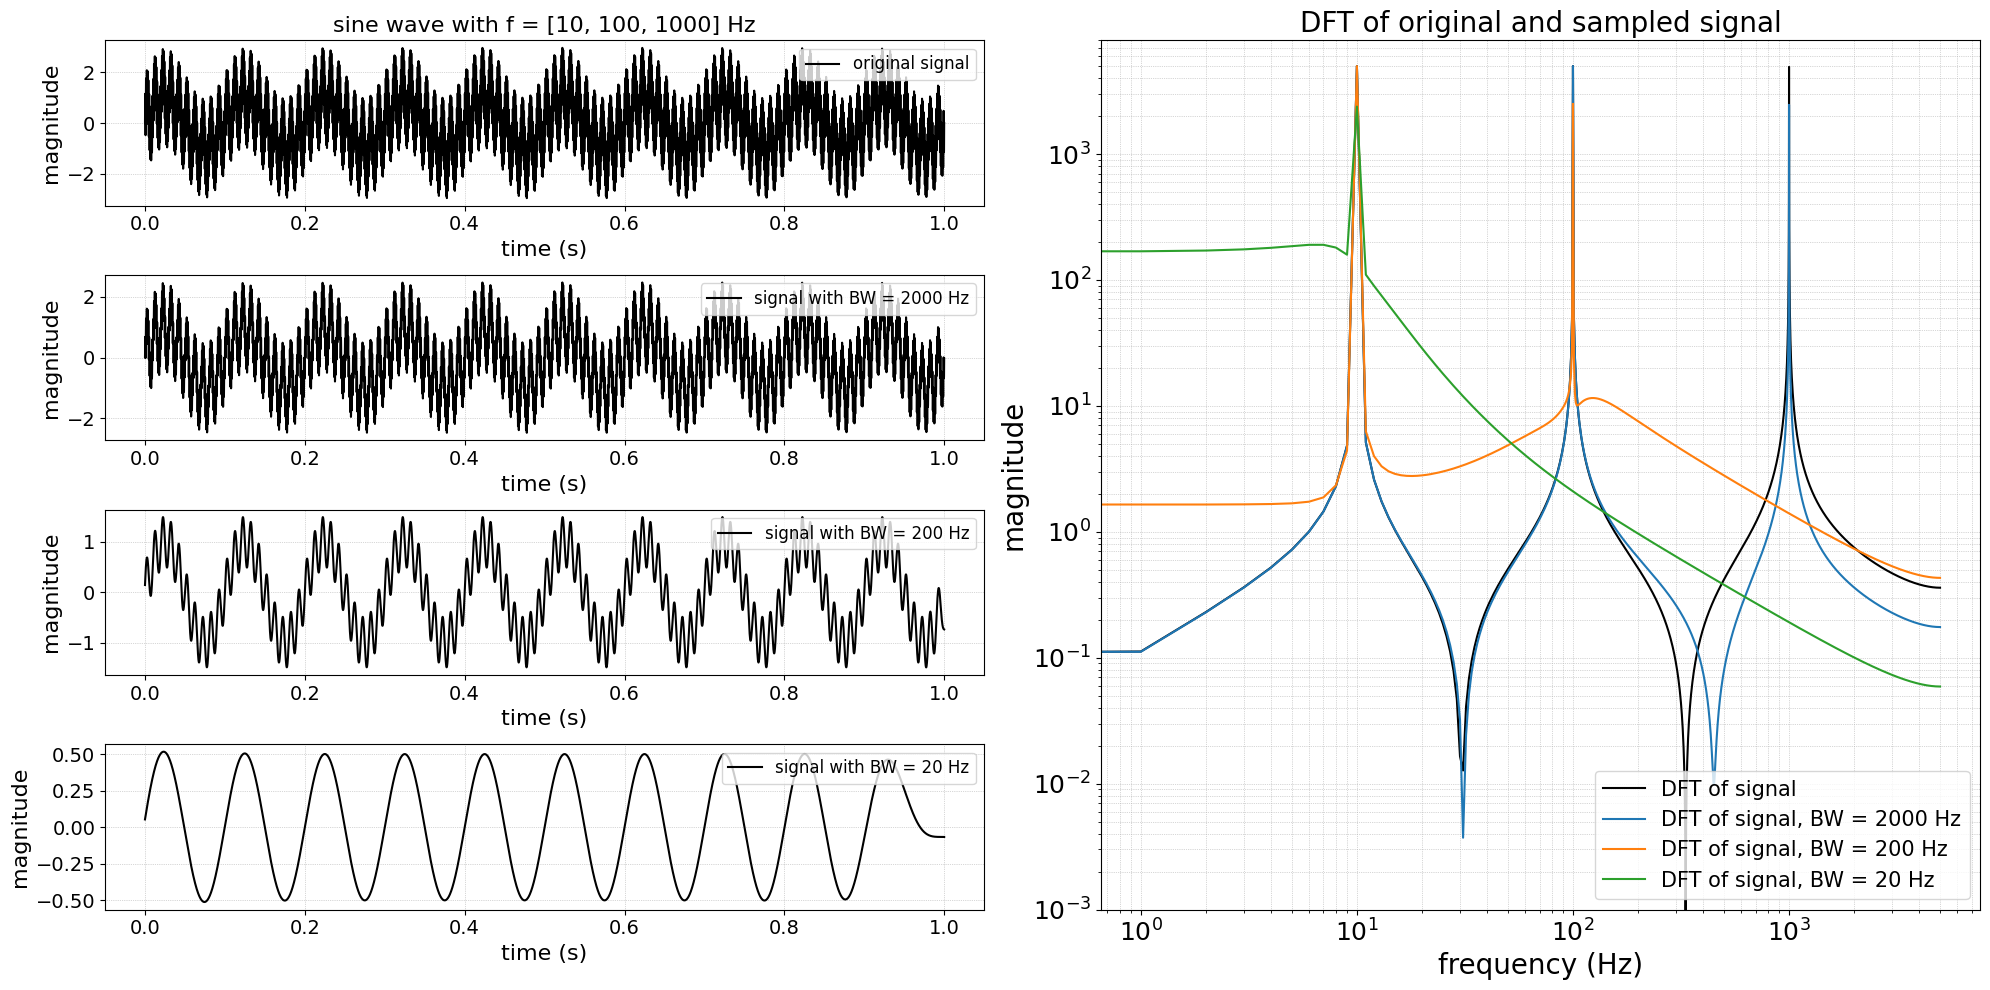

In [13]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(20, 10))  # Removed constrained_layout

# --- Left Subplots ---

# Original Signal
ax1 = plt.subplot(421)
plt.plot(t, sine_signal, color='black', label=f'original signal')
plt.gca().set_title(f'sine wave with f = {f_test} Hz', fontsize=16)  # Reduced font size
plt.xlabel('time (s)', fontsize=16)
plt.ylabel('magnitude', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.legend(loc='upper right', fontsize=12)

# Bandwidth-Limited Signals
sub_time = [423, 425, 427]
for i in range(len(sub_time)):
    ax = plt.subplot(sub_time[i])
    sig1 = BW_limt(sine_signal, BW[i], 1/(t[1] - t[0]))
    plt.plot(t, sig1, color='black', label=f'signal with BW = {BW[i]} Hz')
    plt.xlabel('time (s)', fontsize=16)
    plt.ylabel('magnitude', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(which='both', linestyle=':', linewidth='0.5')
    plt.legend(loc='upper right', fontsize=12)

# --- Right Subplot ---

# FFT Plots
ax2 = plt.subplot(122)
plt.loglog(f_plot, fft_sine_signal, color='black', label=f'DFT of signal')
for i in range(len(BW)):
    sig1 = BW_limt(sine_signal, BW[i], 1/(t[1] - t[0]))
    f_p, fft_mag = compute_fourier_transform(sig1, 1/(t[1] - t[0]))
    plt.loglog(f_p, fft_mag, label=f'DFT of signal, BW = {BW[i]} Hz')
plt.xlabel('frequency (Hz)', fontsize=20)
plt.ylabel('magnitude', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.legend(loc='lower right', fontsize=15)
plt.gca().set_title(f'DFT of original and sampled signal', fontsize=20)
plt.ylim(1e-3, 8e3)

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Increased spacing
plt.tight_layout()
plt.savefig('BW_limit.png')
plt.show()


## 2.1.2 Non-monotonic signal (white noise? ) 

White noise provide a wide spectrum compared to sine wave 

1. Generate a white noise spectrum

In [14]:
f_test = [10,100,1000]
t = np.linspace(0,1,1000000)
#generating an array with different frequency refer to f_test 
white_noise = gen_noise(1, 1/len(t))[1]
# print(white_noise)
# fft of the signal 
f_plot, fft_white_signal = compute_fourier_transform(white_noise, len(t))


2. Bandwidth limit the signal (using Butterworth LPF)

3. Sampling this signal with two case: 
    * Undersampling
    * Oversampling

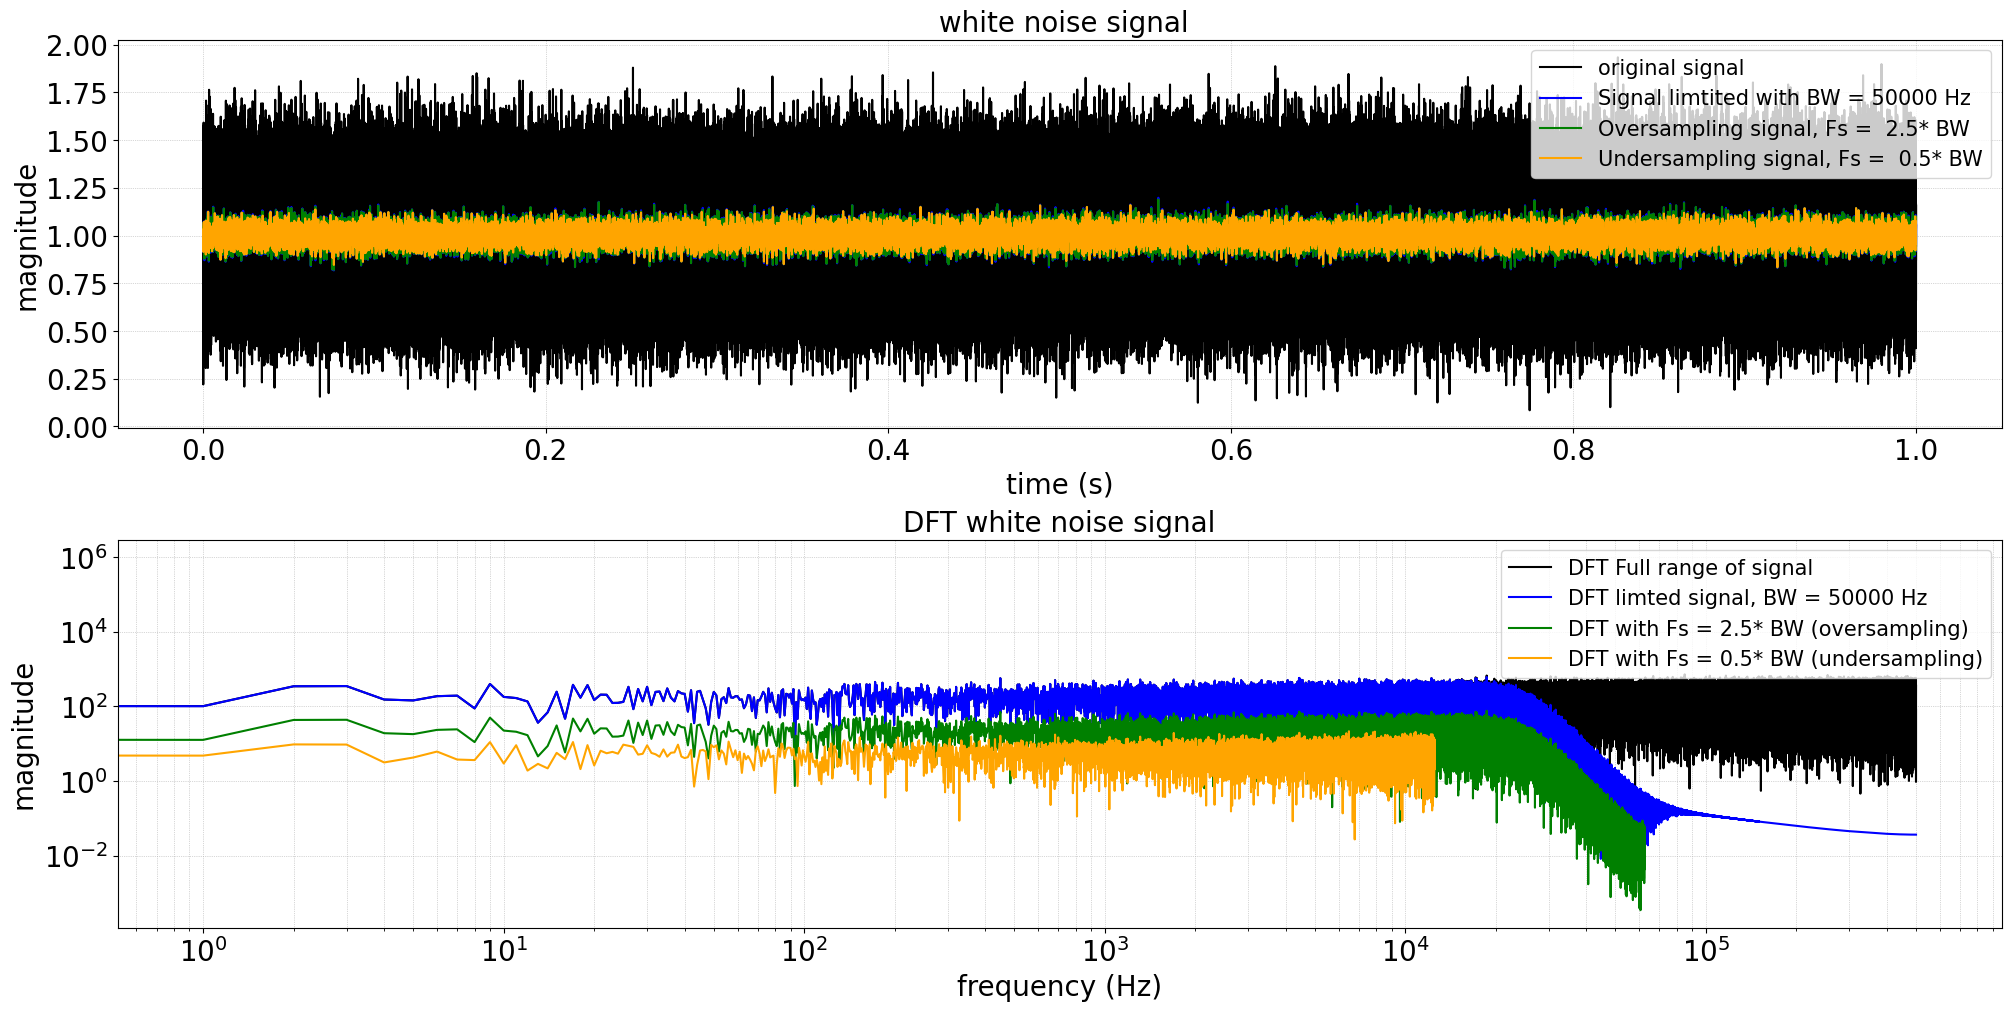

In [34]:
BW = [50000] # [Hz]
#sampled data 
Fs1 = 2.5 * BW[0] # [Hz], case for oversampling

Fs2 = 0.5 * BW[0] # [Hz], case for undersampling 

plt.figure(figsize = (20,10) , constrained_layout=True)
plt.subplot(211)

# apply BW limited on original white noise signal
sig1 = BW_limt(white_noise, BW[0], 1/(t[1] - t[0]))

# sampling BW limited signal with Fs = 2.5 * BW [Hz]
t_samp1, sig_samp1 = sampling(t, sig1, Fs1,offset=0, jitter=0)

# sampling BW limited signal with Fs = 0.5 * BW [Hz]
t_samp2, sig_samp2 = sampling(t, sig1, Fs2,offset=0, jitter=0)



plt.plot(t,white_noise, color = 'black', label = f'original signal')
plt.plot(t,sig1, color = 'blue', label = f'Signal limtited with BW = {BW[0]} Hz')
plt.plot(t_samp1, sig_samp1, color = 'green', label = f'Oversampling signal, Fs =  {Fs1 / BW[0]}* BW')
plt.plot(t_samp2, sig_samp2, color = 'Orange', label = f'Undersampling signal, Fs =  {Fs2 / BW[0]}* BW')

plt.gca().set_title(f' white noise signal', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.ylabel('magnitude', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.legend(loc = 'upper right',fontsize = 15)
plt.subplot(212)

f_p, fft_mag = compute_fourier_transform(sig1, 1/(t[1] - t[0]))
plt.loglog(f_plot, fft_white_signal, color = 'black', label = f'DFT Full range of signal')
plt.loglog(f_p, fft_mag, color = 'blue',  label = f'DFT limted signal, BW = {BW[0]} Hz')


f_samp1, fft_sigsamp1 = compute_fourier_transform(sig_samp1, Fs1)
plt.loglog(f_samp1, fft_sigsamp1, color = 'green',  label = f'DFT with Fs = {Fs1 / BW[0]}* BW (oversampling)')

f_samp2, fft_sigsamp2 = compute_fourier_transform(sig_samp2, Fs2)
plt.loglog(f_samp2, fft_sigsamp2, color = 'orange',  label = f'DFT with Fs = {Fs2 / BW[0]}* BW (undersampling)')



plt.gca().set_title(f'DFT white noise signal', fontsize = 20)
plt.xlabel('frequency (Hz)', fontsize = 20)
plt.ylabel('magnitude', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.legend(loc = 'upper right', fontsize = 15)


## 3. Problem with measurement time 

### 1. Longer measurement, better resolution 

1. Generate 3 random signal with same step and different duration. Apply the test on random stationary noise 

In [35]:
t1 = 1
t2 = 10
t3 = 1000
step = 1/1000

# 3 period of time 
def gen_noise(t, step):
    noise = []
    mu = 1
    sigma = 0.2
    for i in range((int(round((t/step))))):
        temp = random.gauss(mu, sigma)
        noise.append(temp)
    return np.arange(0,t,step), noise
    

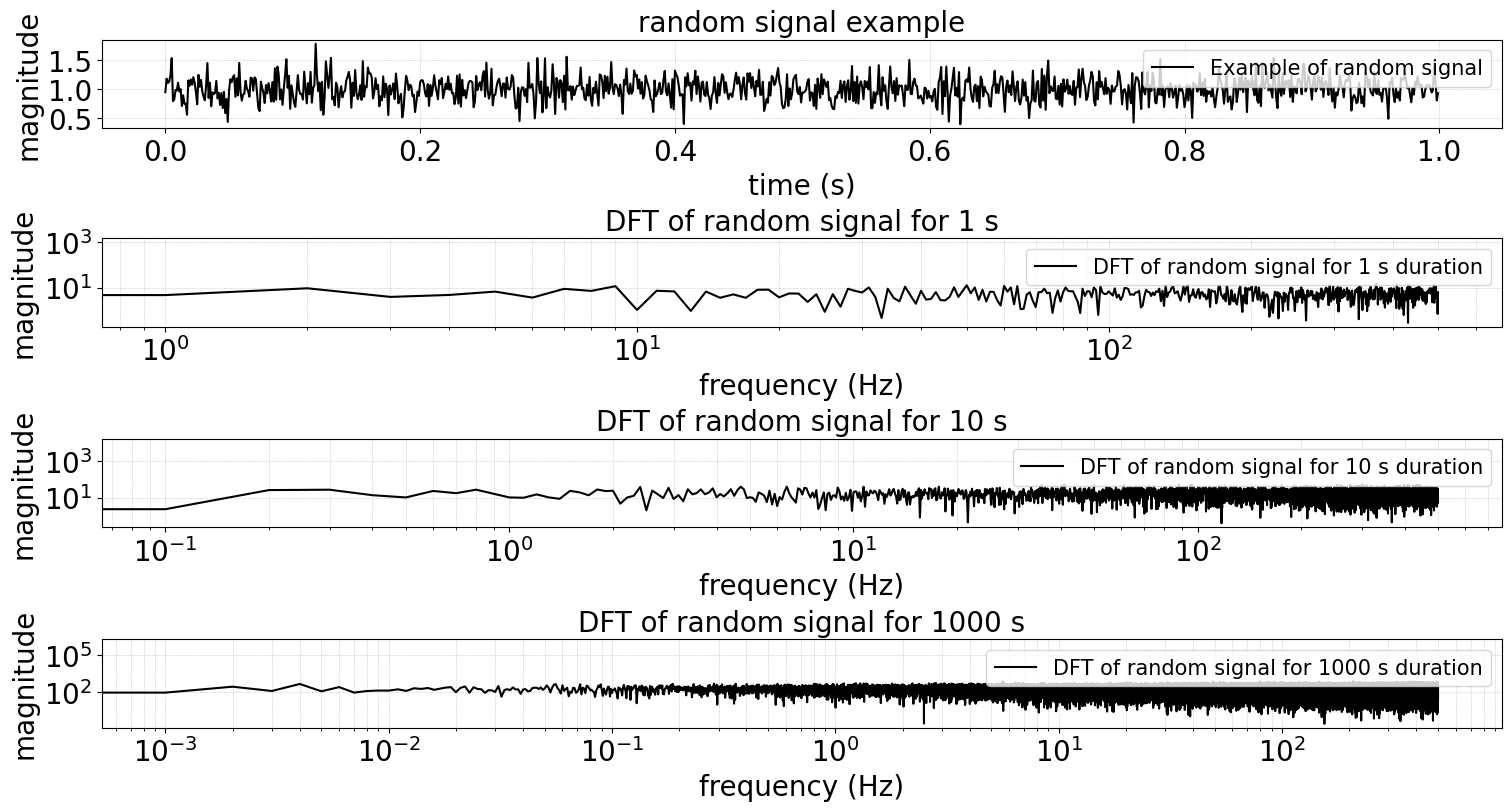

In [37]:
t = [t1,t2,t3]
plt.figure(figsize = (15,8), constrained_layout=True)
plt.subplot(411)
plt.plot(gen_noise(t1, step)[0], gen_noise(t1, step)[1], color = 'black', label ='Example of random signal')
plt.gca().set_title(f'random signal example', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.ylabel('magnitude', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.legend(loc = 'upper right',fontsize = 15)
sub = [412,413,414]
for i in range(len(sub)):
    plt.subplot(sub[i])
    sig = gen_noise(t[i], step)[1]
    f1,mag1 = compute_fourier_transform(sig,1/step)
    plt.loglog(f1,mag1, color = 'black', label = f'DFT of random signal for {t[i]} s duration')
    plt.gca().set_title(f'DFT of random signal for {t[i]} s', fontsize = 20)
    plt.xlabel('frequency (Hz)', fontsize = 20)
    plt.ylabel('magnitude', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.grid(which='both', linestyle=':', linewidth='0.5')
    plt.legend(loc = 'upper right', fontsize = 15)
plt.savefig('stationary_increase_time.png')

2. Prove that averaging signal can reduce SNR

averaging with different averaging time 

In [38]:
time_max = 1000
avg_factor = []
a = time_max 
avg_factor = []
for i in range(1, time_max + 1):
  if time_max % i == 0:
    avg_factor.append(i) 
print(avg_factor)
    
# div = []
# for i in fac:
#     div.append(10*i)
# div = time_avg
# std = []
rand_arr = gen_noise(1000, step)[1]
avg_factor = np.flip(avg_factor)
def calculate_std_of_averaged_signal(rand_arr, avg_factor):
    """
    Calculates the standard deviation of a signal averaged over 
    different block sizes.

    Args:
      rand_arr: The input signal (array-like).
      avg_factor: An array of averaging factors (block sizes).

    Returns:
      std_arr: An array of standard deviations corresponding to the avg_factor.
    """

    std_arr = np.zeros(len(avg_factor))
    for k, i in enumerate(avg_factor):
        n = len(rand_arr) // i  # Number of blocks
        sig0 = np.zeros(n)
        for j in range(n):
            start = j * i
            end = (j + 1) * i
            sig0[j] = np.mean(rand_arr[start:end])  # Average each block
        std_arr[k] = np.std(sig0)  # Calculate std for the current block size
    return std_arr

# Example usage (assuming rand_arr and avg_factor are defined)
std_arr = calculate_std_of_averaged_signal(rand_arr, avg_factor)
print(avg_factor)
print(std_arr)


[1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 1000]
[1000  500  250  200  125  100   50   40   25   20   10    8    5    4
    2    1]
[0.00622775 0.00877196 0.01250742 0.01407646 0.01791832 0.01996531
 0.02827423 0.03160884 0.0399637  0.0448645  0.06332782 0.07084246
 0.08935166 0.10004993 0.14154023 0.20010406]


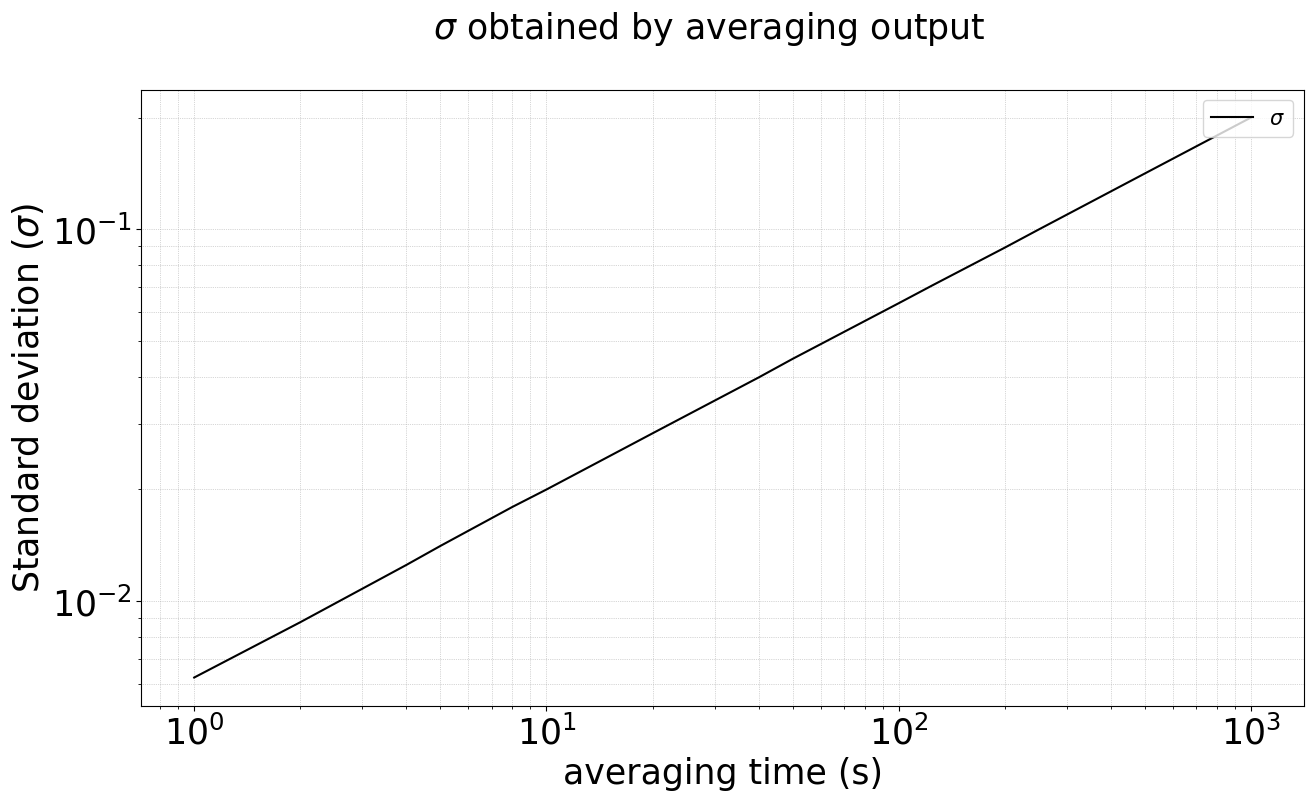

In [39]:
plt.figure(figsize = (15,8))

plt.loglog(np.flip(avg_factor), std_arr, color = 'black', label = r'$\sigma$')
plt.xlabel('averaging time (s)', fontsize = 25)
plt.ylabel(r'Standard deviation $(\sigma)$', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(loc = 'upper right',fontsize = 15)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.suptitle(r' $\sigma$ obtained by averaging output', fontsize = 25) 
plt.savefig('sigma_cal.png')

### Using spectrum of flicker noise (1/f) as an non-stationary noise source

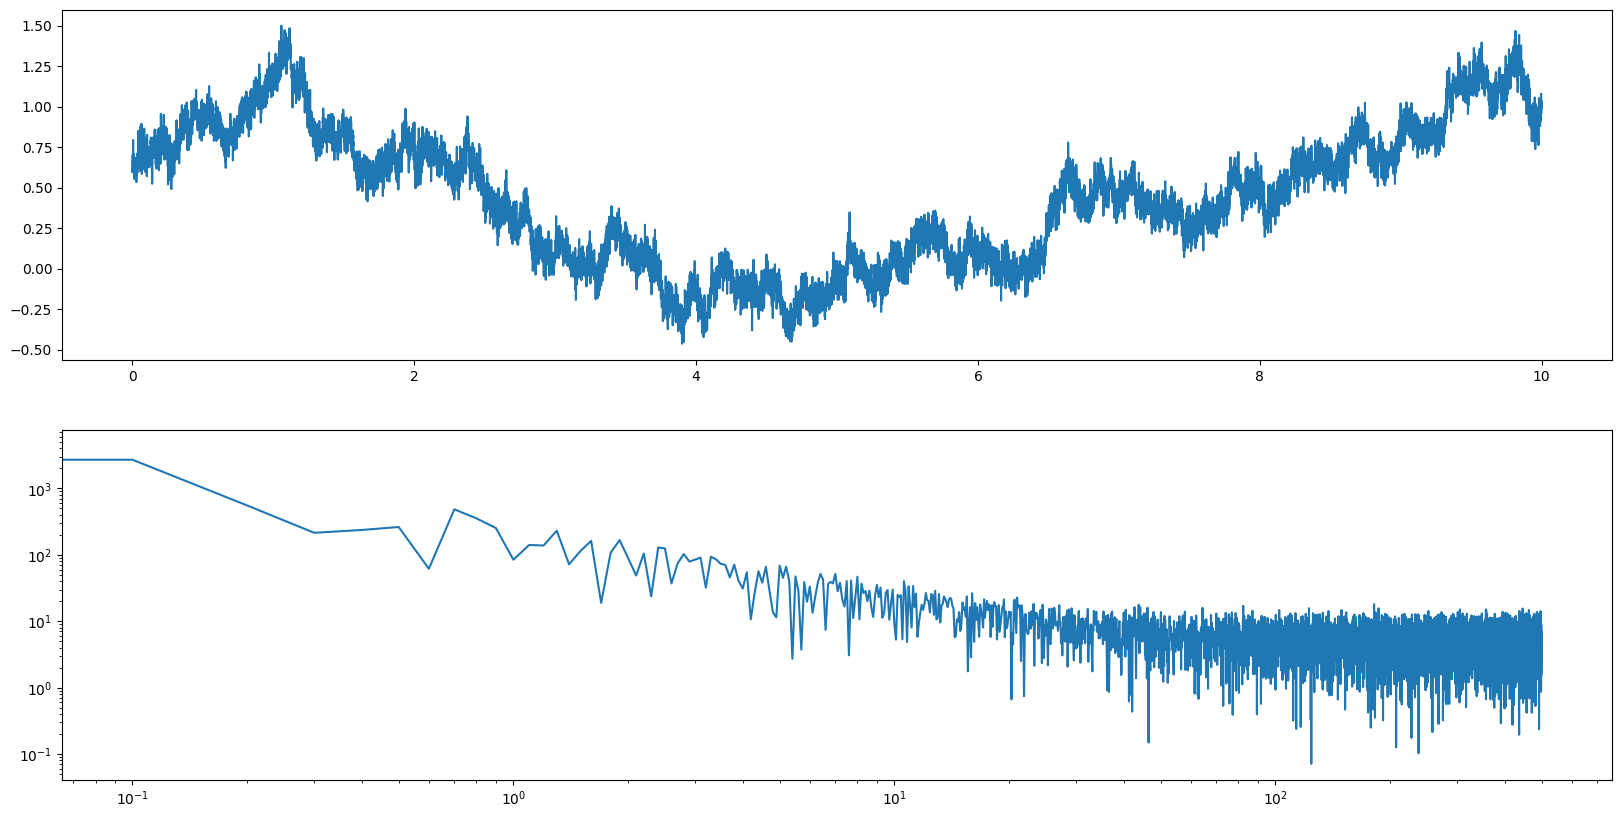

In [41]:
f = np.linspace(1e-3, 1e3, 1000)
y = 1/f 

import numpy as np
import random

def gen_non_stationary_noise(t, step, mu, sigma):
    """
    Generates non-stationary noise by adding flicker noise to 
    Gaussian noise with a time-varying mean.

    Args:
      t: Duration of the noise signal in seconds.
      step: Time step in seconds.
      mu: Mean of the Gaussian noise.
      sigma: Standard deviation of the Gaussian noise.

    Returns:
      time_vector: Time vector.
      noise: Non-stationary noise signal.
    """

    # Generate Gaussian noise with time-varying mean
    num_samples = int(t / step)  # Calculate the number of samples
    time_vector = np.arange(0, t, step)
    noise = np.zeros(num_samples)  # Initialize noise array with the correct size
    for i in range(num_samples):
        mu_t = mu + 0.1 * time_vector[i]  # Linearly increasing mean (you can adjust this)
        noise[i] = random.gauss(mu_t, sigma)

    # Generate flicker noise (with the same number of samples)
    N = num_samples
    f = np.fft.fftfreq(N, 1/step)
    f[0] = 1  # Avoid division by zero
    flicker_spectrum = 1 / np.abs(f)
    flicker_spectrum[0] = 0  # Set DC component to zero
    phases = np.random.uniform(0, 2*np.pi, N)
    flicker_fft = flicker_spectrum * np.exp(1j * phases)
    flicker_noise = np.fft.ifft(flicker_fft)
    flicker_noise = np.real(flicker_noise)

    # Combine Gaussian noise and flicker noise
    noise += flicker_noise*0.001  # Add flicker noise to the Gaussian noise

    return time_vector, noise/(max(noise)/1.5)




# plt.figure(figsize = (15,10))
# plt.subplot(211)
# plt.loglog(y)
# plt.subplot(212)
# y += gen_noise(1, 1/1000)[1]
# ifft_y = np.fft.ifft(y, len(f))
# plt.plot(ifft_y[1:len(ifft_y)])
plt.figure(figsize = (20,10))
plt.subplot(211)
t_test, mag_test = gen_non_stationary_noise(t2, step, 1, 0.2)
plt.plot(t_test,mag_test)
plt.subplot(212)
f_test,mag_test = compute_fourier_transform(mag_test, 1/step)
plt.loglog(f_test, mag_test)

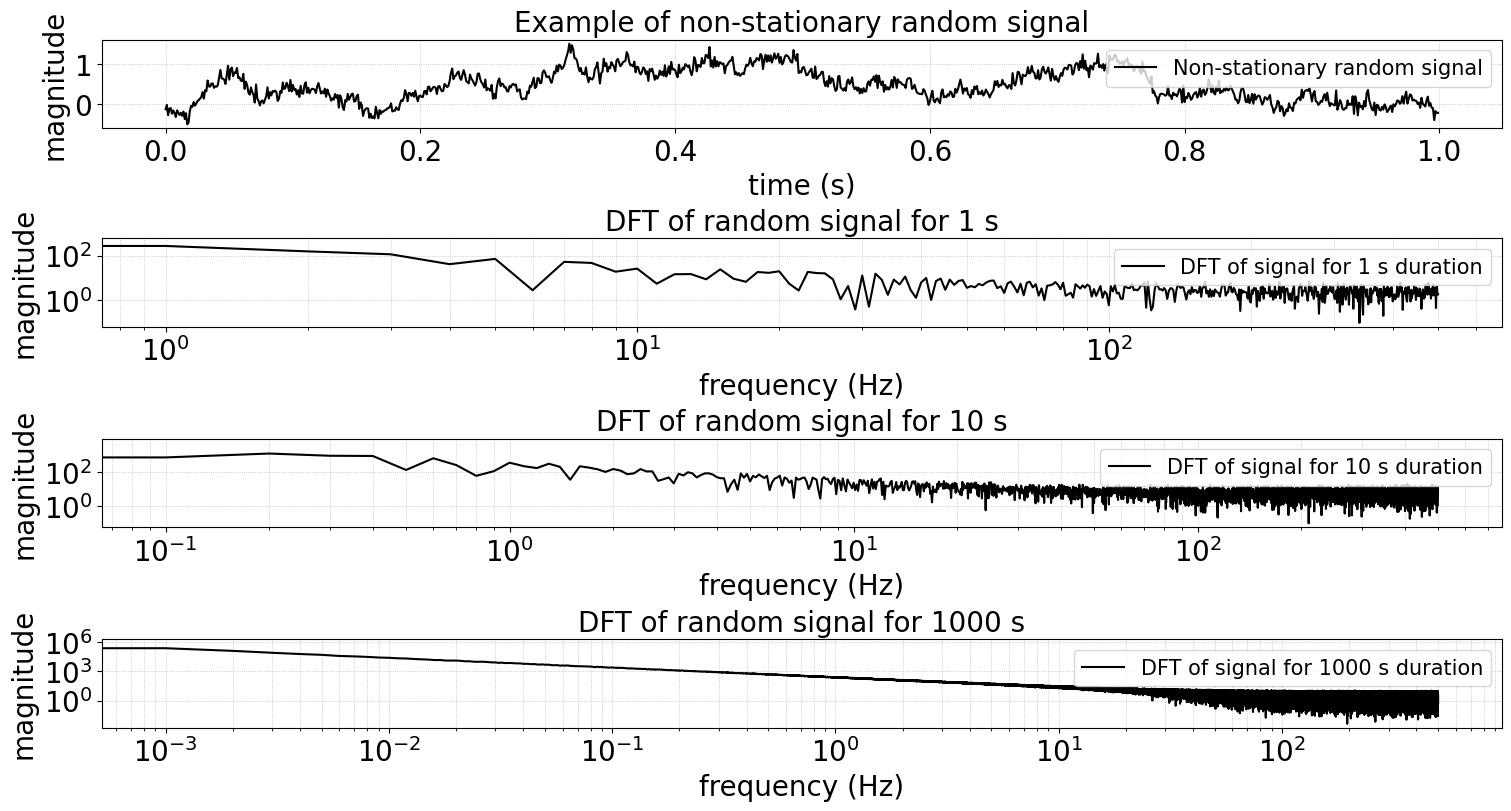

In [43]:
t = [t1,t2,t3]
plt.figure(figsize = (15,8), constrained_layout=True)
plt.subplot(411)
plt.plot(gen_non_stationary_noise(t1, step, 1, 0.2 )[0], gen_non_stationary_noise(t1, step, 1, 0.2 )[1], color = 'black', label ='Non-stationary random signal')
plt.gca().set_title(f'Example of non-stationary random signal', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.ylabel('magnitude', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.legend(loc = 'upper right',fontsize = 15)
sub = [412,413,414]
for i in range(len(sub)):
    plt.subplot(sub[i])
    sig = gen_non_stationary_noise(t[i], step, 1, 0.2 )[1]
    f1,mag1 = compute_fourier_transform(sig,1/step)
    plt.loglog(f1,mag1, color = 'black', label = f'DFT of signal for {t[i]} s duration')
    plt.gca().set_title(f'DFT of random signal for {t[i]} s', fontsize = 20)
    plt.xlabel('frequency (Hz)', fontsize = 20)
    plt.ylabel('magnitude', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.grid(which='both', linestyle=':', linewidth='0.5')
    plt.legend(loc = 'upper right', fontsize = 15)
plt.savefig('non_stationary_increase_time.png')

In [44]:
time_max = 10000
avg_factor = []
a = time_max 
avg_factor = []
for i in range(1, time_max + 1):
  if time_max % i == 0:
    avg_factor.append(i) 
print(avg_factor)
    
# div = []
# for i in fac:
#     div.append(10*i)
# div = time_avg
# std = []
rand_arr = gen_non_stationary_noise(time_max, step, 1, 0.2 )[1]
avg_factor = np.flip(avg_factor)

# Example usage (assuming rand_arr and avg_factor are defined)
std_arr = calculate_std_of_averaged_signal(rand_arr, avg_factor)
print(avg_factor)
print(std_arr)

[1, 2, 4, 5, 8, 10, 16, 20, 25, 40, 50, 80, 100, 125, 200, 250, 400, 500, 625, 1000, 1250, 2000, 2500, 5000, 10000]
[10000  5000  2500  2000  1250  1000   625   500   400   250   200   125
   100    80    50    40    25    20    16    10     8     5     4     2
     1]
[0.43217707 0.43217723 0.43217728 0.43217728 0.43217729 0.43217729
 0.43217729 0.43217729 0.43217729 0.43217729 0.43217729 0.43217729
 0.43217729 0.43217729 0.43217729 0.43217729 0.4321773  0.4321773
 0.4321773  0.4321773  0.4321773  0.43217731 0.43217732 0.43217734
 0.4321774 ]


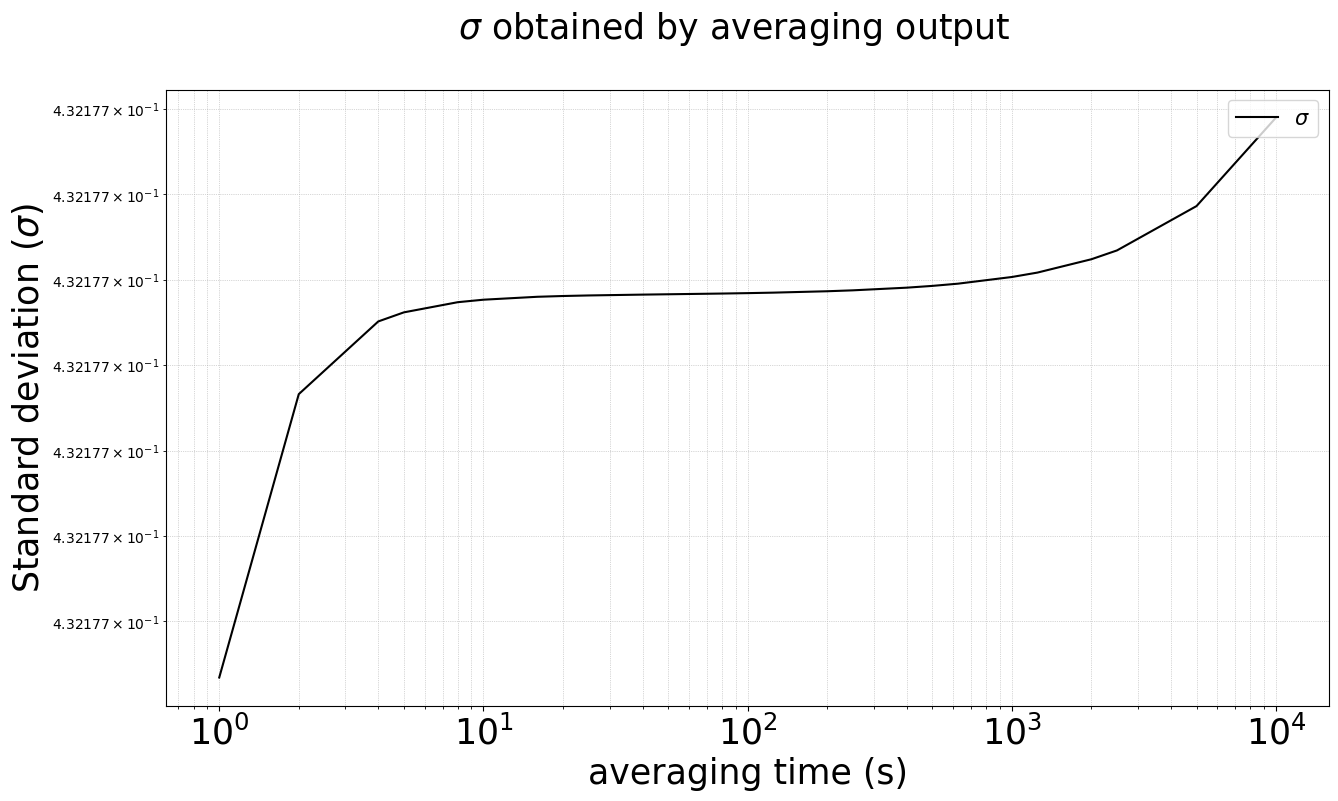

In [45]:
plt.figure(figsize = (15,8))

plt.loglog(np.flip(avg_factor), std_arr, color = 'black', label = r'$\sigma$')
plt.xlabel('averaging time (s)', fontsize = 25)
plt.ylabel(r'Standard deviation $(\sigma)$', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(loc = 'upper right',fontsize = 15)
plt.grid(which='both', linestyle=':', linewidth='0.5')
plt.suptitle(r' $\sigma$ obtained by averaging output', fontsize = 25) 
plt.savefig('sigma_nonsta_cal.png')